In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float16, variant="fp16")

device = torch.device("cuda:1")
seed = 5
pipe.to(device)

prompt = "a photo of a car"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0, seed=seed).images[0]


/opt/conda/envs/reno/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████

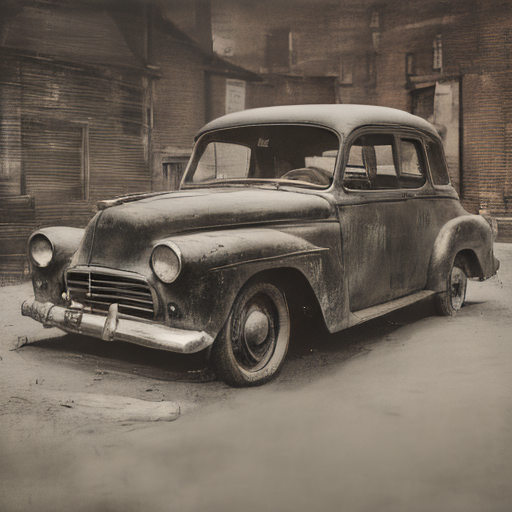

In [2]:
image

In [3]:
pipe.scheduler

EulerDiscreteScheduler {
  "_class_name": "EulerDiscreteScheduler",
  "_diffusers_version": "0.30.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "final_sigmas_type": "zero",
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "sigma_max": null,
  "sigma_min": null,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "trailing",
  "timestep_type": "discrete",
  "trained_betas": null,
  "use_karras_sigmas": false
}

In [4]:
from rewards.orient import OrientLoss
from torchvision.transforms import ToTensor, ToPILImage
import torch
import numpy as np

orientation = [0, 90, 90]
to_tensor = ToTensor()
reward_loss = OrientLoss(1.0, torch.float16, device, '/root/.cache/huggingface/hub', False)

image
loss = reward_loss(to_tensor(image).to(device), np.array(orientation))

print(loss)





large
azimuth: 27
polar: 91
rotation: 90
tensor(1.8057, device='cuda:1', dtype=torch.float16)


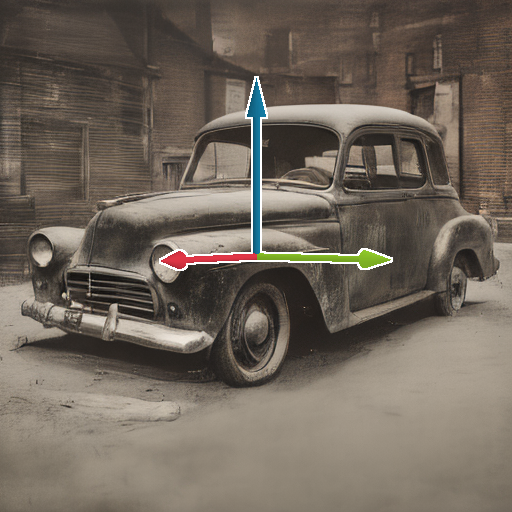

In [7]:
from orient_anything import get_3angle, render_3D_axis, overlay_images_with_scaling
from transformers import AutoImageProcessor
val_preprocess = AutoImageProcessor.from_pretrained("facebook/dinov2-large", cache_dir='./')

angles = get_3angle(image, reward_loss.orient_estimator, val_preprocess, device)
azimuth = float(np.radians(angles[0]))
polar = float(np.radians(angles[1]))
rotation = float(angles[2])
confidence = float(angles[3])

render_axis = render_3D_axis(azimuth, polar, rotation)
res_img = overlay_images_with_scaling(render_axis, image)

res_img